<a href="https://colab.research.google.com/github/werd0n4/hand-gesture-classification/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [47]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
!ls

drive  sample_data


In [49]:
import pandas as pd
import numpy as np

import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import os
import cv2
import glob
import random
from matplotlib import pyplot as plt

## Constant parameters

In [50]:
horiz_x = 174
vert_y = 131
imgs_dir_path = '/content/drive/My Drive/Colab Notebooks/hgr1_original_images'

In [51]:
class_ids = {
    "1_P": 0, 
    "2_P": 1,
    "3_P": 2,
    "4_P": 3,
    "5_P": 4,
    "A_P": 5,
    "B_P": 6,
    "C_P": 7,
    "D_P": 8,
    "E_P": 9,
    "F_P": 10,
    "G_P": 11,
    "H_P": 12,
    "I_P": 13,
    "K_P": 14,
    "L_P": 15,
    "M_P": 16,
    "N_P": 17,
    "O_P": 18,
    "P_P": 19,
    "R_P": 20,
    "S_P": 21,
    "T_P": 22,
    "U_P": 23,
    "W_P": 24,
    "Y_P": 25,
    "Z_P": 26
}

class_names = {
    0: "Polish number one",
    1: "Polish number two",
    2: "Polish number three",
    3: "Polish number four",
    4: "Polish number five",
    5: "Polish letter A",
    6: "Polish letter B",
    7: "Polish letter C",
    8: "Polish letter D",
    9: "Polish letter E",
    10: "Polish letter F",
    11: "Polish letter G",
    12: "Polish letter H",
    13: "Polish letter I",
    14: "Polish letter K",
    15: "Polish letter L",
    16: "Polish letter M",
    17: "Polish letter N",
    18: "Polish letter O",
    19: "Polish letter P",
    20: "Polish letter R",
    21: "Polish letter S",
    22: "Polish letter T",
    23: "Polish letter U",
    24: "Polish letter W",
    25: "Polish letter Y",
    26: "Polish letter Z"
}

print(class_ids["1_P"])

0



# Auxiliary functions

In [52]:

def resize(path):
    img_counter = 0
    
    for filename in os.listdir(path):
        image_path = os.path.join(path, filename)
        # print(image_path)
        img = cv2.imread(image_path)
        resized_img = cv2.resize(img, (horiz_x, vert_y))
        cv2.imwrite(image_path, resized_img)
        img_counter += 1
    
    print('Images in set: ' + str(img_counter))


In [53]:

def sanity_check(path):
    counter = 0

    for filename in os.listdir(path):
        image_path = os.path.join(path, filename)
        img = cv2.imread(image_path)
        if img.shape != (horiz_x, vert_y, 3):
            counter += 1

    print('Sanity result: ' + str(counter))

In [54]:

def show_img(index, X, Y):
    # plt.imshow(X[index])
    plt.imshow(cv2.cvtColor(X[index],cv2.COLOR_BGR2RGB).astype('float32'))
    plt.show()
    nmb = int(np.where(Y[index] == 1)[0])
    print(class_names[nmb])

## Load dataset

In [55]:

def load_dataset(path):
    filelist = glob.glob(f'{imgs_dir_path}/*')
    X = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist] )

    # Y = np.array([np.zeros(27) for fname in filelist])
    Y = np.array([0 for fname in filelist])
    for i,fname in enumerate(filelist):
        filename = fname.split('/')[-1]
        fileid = str(filename[:3])
        # print(fileid)
        # print(class_ids[fileid])
        # Y[i][class_ids[fileid]] = 1
        Y[i] = class_ids[fileid]

    return X, Y

## Create network model

In [56]:

def create_model():
    model = Sequential()
    
    model.add(Conv2D(
        filters=6, 
        kernel_size=(5,5), 
        input_shape=(131, 174, 3), 
        activation='relu'
    ))
    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    ))

    model.add(Conv2D(
        filters=16, 
        kernel_size=(5,5), 
        input_shape=(62, 84, 6), 
        activation='relu'
    ))
    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    ))


    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(27, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


# Loading dataset

In [57]:
### Uncomment if neccessary
# resize(imgs_dir_path)
# sanity_check(imgs_dir_path
###

In [ ]:
X, Y = load_dataset(imgs_dir_path)

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [64]:
Y_cat_train = to_categorical(Y_train)
Y_cat_test = to_categorical(Y_test)

# Create and train model

In [65]:
CNN = create_model()
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 127, 170, 6)       456       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 85, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 81, 16)        2416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 40, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18560)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               2375808   
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [66]:
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [67]:
CNN.fit(X_train, Y_cat_train, epochs=26, validation_data=(X_test, Y_cat_test), callbacks=[early_stop])

Epoch 1/26
23/23 [==============================] - 1s 37ms/step - loss: 3.4007 - accuracy: 0.0431 - val_loss: 3.3009 - val_accuracy: 0.0222
Epoch 2/26
23/23 [==============================] - 1s 26ms/step - loss: 3.2825 - accuracy: 0.0487 - val_loss: 3.2624 - val_accuracy: 0.0833
Epoch 3/26
23/23 [==============================] - 1s 26ms/step - loss: 3.1234 - accuracy: 0.1321 - val_loss: 3.1266 - val_accuracy: 0.0944
Epoch 4/26
23/23 [==============================] - 1s 26ms/step - loss: 2.6312 - accuracy: 0.2545 - val_loss: 2.8780 - val_accuracy: 0.1667
Epoch 5/26
23/23 [==============================] - 1s 25ms/step - loss: 1.8773 - accuracy: 0.4910 - val_loss: 2.7197 - val_accuracy: 0.2222
Epoch 6/26
23/23 [==============================] - 1s 26ms/step - loss: 1.2622 - accuracy: 0.6217 - val_loss: 2.7842 - val_accuracy: 0.2278


In [84]:
metrics = pd.DataFrame(CNN.history.history)
metrics

""


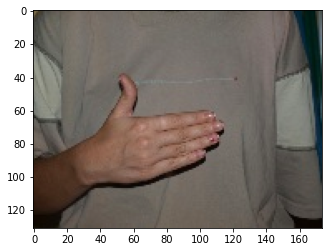

Polish letter M


In [75]:
my_hand = X_test[0]
show_img(0, X_test, Y_cat_test)

In [86]:
#CNN.predict_classes(my_hand.reshape(1, 131, 174, 3))
my_hand = my_hand.reshape(1, 131, 174, 3)
result = CNN.predict_classes(my_hand)
# result = np.argmax(CNN.predict(my_hand.reshape(1, 131, 174, 3)), axis=-1)
result = int(result)
print('CNN says: ' + class_names[result])

CNN says: Polish letter N


In [77]:
predictions = CNN.predict_classes(X_test)

In [79]:
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.40      0.44         5
           2       0.00      0.00      0.00         6
           3       0.75      0.38      0.50         8
           4       0.20      0.60      0.30         5
           5       0.29      0.29      0.29         7
           6       0.09      0.50      0.15         4
           7       0.14      0.40      0.21         5
           8       0.00      0.00      0.00         8
           9       0.22      0.40      0.29         5
          10       0.00      0.00      0.00         8
          11       0.27      0.38      0.32         8
          12       0.00      0.00      0.00         6
          13       0.20      0.17      0.18         6
          14       0.20      0.25      0.22         4
          15       0.50      0.25      0.33         4
          16       0.00      0.00      0.00         9
          17       0.13    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
